# Quantization of pre-trained Image Transformers

This notebook tries to establish a baseline with different quantization techniques as well as visualizations.

* [SegFormer Part 3, Quantization Description](https://qte77.github.io/SegFormer-Part3-Quantization-Description/)
* [SegFormer Part 4, Quantization Difficulties and Errors Part 1](https://qte77.github.io/SegFormer-Part4-Quantization-Difficulties-Part1/)

# Prelims

In [1]:
try:
  from google.colab import drive
  google_colab = True
except ImportError:
  from os.path import basename
  google_colab = False

## Params

In [2]:
project_name = "SegFormer"
nb_name = "hf_segformer_quant_PoC.ipynb"

In [3]:
model_checkpoints = {
    # "swintiny": "microsoft/swin-tiny-patch4-window7-224", # not implemented
    # "b0ade": "nvidia/segformer-b0-finetuned-ade-512-512", # not implemented
    "b0": "nvidia/mit-b0"
}
# tasks = ["classification", "segmentation"] # not implemented

In [4]:
dataset_url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
ds_num_shards = 1000 # higher faster

In [5]:
batch_size = 32
num_train_epochs = 10
metric_to_load = "accuracy" # accuracy for cls, mean_iou for seg
test_calculation_speed = True

## Param prep

In [6]:
model_checkpoint = model_checkpoints['b0']
model_name = model_checkpoint.split("/")[-1]
dataset_name = dataset_url.split("/")[-1].split(".")[0]

In [7]:
from pathlib import Path
if google_colab:
  MNT_PATH = Path("/content/drive")
  SAVE_PATH = MNT_PATH / "MyDrive"
  NB_PATH = SAVE_PATH / "Colab Notebooks"
  nb_name = "hf_segformer_quant_PoC.ipynb"
else:
  SAVE_PATH = Path(".")
  NB_PATH = Path(".")
  nb_name = basename(__file__)

In [8]:
NB_PATH = NB_PATH / f"{project_name}/PoC"
DS_PATH = SAVE_PATH / f"Datasets/{dataset_name}"
MODEL_PATH = SAVE_PATH / f"Models/{model_checkpoint}"
TOK_PATH = SAVE_PATH / f"Tokenizer/{model_checkpoint}"
PY_PATH = NB_PATH / "utils"
REQS_PATH = NB_PATH / "reqs"

In [9]:
if google_colab: drive.mount(str(MNT_PATH))
NB_PATH.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


## Imports

In [12]:
for req in ["requirements_quant.txt"]: #, "requirements_jupymill.txt"]:
  req_file = REQS_PATH / req
  assert req_file.exists(), "Not Again!"
  %pip install -qqr "{req_file}"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 73.6 MB/s eta 0:00:00


In [13]:
# huggingface
from datasets import load_dataset, load_from_disk
from evaluate import load
from transformers.trainer_utils import EvalPrediction
from transformers import (
  AutoImageProcessor,
  # SegformerForSemanticSegmentation,
  SegformerForImageClassification,
  TrainingArguments,
  Trainer
)

In [14]:
# tensor
from numpy import argmax
from torchinfo import summary
from torch import (
    ge, zeros,
    stack, tensor, where,
    device, no_grad # autograd.grad_mode
)
# from torch.optim import AdamW
from torchvision.transforms import (
  CenterCrop,
  Compose,
  Normalize,
  RandomHorizontalFlip,
  RandomResizedCrop,
  Resize,
  ToTensor,
)

In [15]:
# quantization
import accelerate
import bitsandbytes

In [16]:
from random import randrange
from os import chdir # , listdir

### Custom utils

In [17]:
chdir(PY_PATH)
from utils import (
    get_device_info, get_calculation_speed,
    get_split_dataset, get_image_processor,
    get_model_as_dict, print_models_stats
)

## Device

In [24]:
deviceinfo = get_device_info()
assert str(deviceinfo['devicename'].type) == "cuda", "GPU needed for quantization"

In [26]:
print("cpu max memory: %s" % deviceinfo["cpu_max_memory"])
if deviceinfo["devicename"].type == "cuda":
  !nvidia-smi
  print("cuda allocated memory: %s" % deviceinfo["cuda_free_mem"])
  print("cuda max memory: %s" % deviceinfo["cuda_max_memory"])

cpu max memory: {'cpu': '12GiB'}
Sat Jun  1 23:55:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              27W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+----------------------------------

## Test calculation speed of dtypes

In [27]:
# https://pytorch.org/docs/stable/tensor_attributes.html#torch.dtype
if test_calculation_speed:
  timings = get_calculation_speed(deviceinfo["devicename"].type, tee=True)

dev='cuda'
torch.float64
mean: 0.013322, stdev: 0.031870
torch.float32
mean: 0.001401, stdev: 0.000248
torch.float16
mean: 0.004340, stdev: 0.002591
torch.bfloat16
mean: 0.002294, stdev: 0.000700
torch.int8
mean: 0.002348, stdev: 0.000415
torch.uint8
mean: 0.001587, stdev: 0.000835
torch.bool
mean: 0.008322, stdev: 0.016917
dev='cpu'
torch.float64
mean: 0.069717, stdev: 0.019679
torch.float32
mean: 0.034468, stdev: 0.001326
torch.float16
mean: 0.371218, stdev: 0.008270
torch.bfloat16
mean: 0.016542, stdev: 0.000850
torch.int8
mean: 0.249495, stdev: 0.004037
torch.uint8
mean: 0.198126, stdev: 0.047961
torch.bool
mean: 0.949305, stdev: 0.234613


# Dataset

In [28]:
dataset = get_split_dataset(str(DS_PATH), dataset_url)

In [29]:
dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 24300
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 2700
 })}

In [30]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

In [31]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 8}

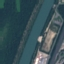

In [32]:
example['image']

In [33]:
example['label']

8

### Preprocessing the data

In [34]:
image_processor = get_image_processor(model_checkpoint, TOK_PATH)
image_processor

Loading from /content/drive/MyDrive/Tokenizer/nvidia/mit-b0.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


SegformerImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [35]:
# on-the-fly image preparation and augmentation with <dataset>.set_transform(<transform_fn>)
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

dataset["train"].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

In [36]:
dataset["train"][0].keys()

dict_keys(['image', 'label', 'pixel_values'])

## Ids and labels

In [37]:
labels = dataset["train"].features["label"].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
id2label

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

# Metric

In [38]:
metric = load(metric_to_load)

In [39]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred: EvalPrediction) -> dict:
    """Computes accuracy on a batch of predictions"""
    predictions = argmax(eval_pred.predictions, axis=1)
    return  metric.compute(
      predictions=predictions,
      references=eval_pred.label_ids
    )

# Model

## Load versions for QAT and compare SPACE/TIME

### 8-bit quantization with bitsandbytes

From [LLM.int8() Paper](https://arxiv.org/abs/2110.02861), [Source GH](https://github.com/TimDettmers/bitsandbytes).
[8-bit HF inference example](https://github.com/TimDettmers/bitsandbytes/blob/main/examples/int8_inference_huggingface.py)

* optimizer
  * `bnb.optim.Adam8bit(....)`
  * `bnb.nn.Embedding(..)`
* inference
  * `linear = bnb.nn.Linear8bitLt(...)`
  * Modes: mixed-precision, int8
  * or full `LLM.int8()` method


`BitsAndBytesConfig` also offers configuration support.

```python
from transformers import BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=bf16)
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)
```

In [40]:
models = {
    "model_base": {"params": {}},
    "model_half": {"params": {"half": True}},
    "model_int8": {"params": {"load_in_8bit": True}},
    "model_int4": {"params": {"load_in_4bit": True}},
}

In [41]:
deviceinfo

{'devicename': device(type='cuda'),
 'cpu_max_memory': {'cpu': '12GiB'},
 'cuda_free_mem': 14,
 'cuda_n_gpus': 1,
 'cuda_max_memory': {0: '14GiB'}}

In [42]:
max_memory = {}
for k,v in {
    **deviceinfo["cpu_max_memory"],
    **deviceinfo["cuda_max_memory"] # CUDA as prereq, so no checking
  }.items():
  v = int(v.replace("GiB", ""))-2
  max_memory[k] = f"{v}GiB"
max_memory

{'cpu': '10GiB', 0: '12GiB'}

In [43]:
# get models
for k,v in models.items():
  print(f"\n{k}: {v}")
  models[k] = get_model_as_dict(
    model_checkpoint, MODEL_PATH,
    max_memory, v["params"]
  )
  print(
    accelerate.infer_auto_device_map(models[k]["model"], max_memory=max_memory)
  )
  print(f"{models[k].keys()}")


model_base: {'params': {}}


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_half: {'params': {'half': True}}
OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_int8: {'params': {'load_in_8bit': True}}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])

model_int4: {'params': {'load_in_4bit': True}}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


OrderedDict([('', 0)])
dict_keys(['load_time', 'model', 'memory_footprint'])


In [55]:
models_stats = {
  k:{
    "load_time": v["load_time"],
    "memory_footprint": v["memory_footprint"],
    #"is_quantized": v["model"].is_quantized,
    "device_map": v["model"].hf_device_map
  } for k,v in models.items()
}

In [59]:
print_models_stats(
  models_stats, models_stats["model_base"]["memory_footprint"]
)

name		size [MiB]	ratio	time	device_map
model_base	13.64		1.0	5.08	{'': device(type='cuda', index=0)}
model_half	6.82		0.5	1.31	{'': device(type='cuda', index=0)}
model_int8	4.62		0.34	1.91	{'': device(type='cuda', index=0)}
model_int4	3.52		0.26	1.56	{'': device(type='cuda', index=0)}


## Test model with example input

---



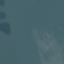

In [60]:
test_image = dataset['train'][0]['image']
inputs = image_processor(images=test_image, return_tensors="pt")
inputs["pixel_values"] = inputs["pixel_values"].to(deviceinfo["devicename"].type)
inputs_halfed = inputs.copy()
inputs_halfed["pixel_values"] = inputs_halfed["pixel_values"].half()
test_image

In [61]:
def infer_model_input_print(
    model_name: str,
    model: SegformerForImageClassification,
    input: dict
) -> None:
  print(model_name)
  with no_grad():
    outputs = model(**input)
  pred_cls_idx = outputs.logits.argmax(-1).item()
  pred_cls_lbl = model.config.id2label[pred_cls_idx]
  print(f"{outputs.keys()=}, {outputs.logits.shape=}")
  print(f"{pred_cls_idx=}, {pred_cls_lbl=}")

In [65]:
#for k in models.keys():
#  input = inputs_halfed if models[k]["model"].is_quantized else inputs
#  infer_model_input_print(k, models[k]["model"], input)

## Summary

* Different amount of non-trainable params

In [66]:
# shape 2d input (C, H, W), 1d (C, L)
#TODO summary with input_size=(batch_size, 3, 512,512)) #, device='cpu')
for m in models.keys():
  sum = summary(models[m]["model"])
  print(f"\n{m}\n{sum}")


model_base
Layer (type:depth-idx)                                                      Param #
SegformerForImageClassification                                             --
├─SegformerModel: 1-1                                                       --
│    └─SegformerEncoder: 2-1                                                --
│    │    └─ModuleList: 3-1                                                 485,472
│    │    └─ModuleList: 3-2                                                 2,832,896
│    │    └─ModuleList: 3-3                                                 1,024
├─Linear: 1-2                                                               257,000
Total params: 3,576,392
Trainable params: 3,576,392
Non-trainable params: 0

model_half
Layer (type:depth-idx)                                                      Param #
SegformerForImageClassification                                             --
├─SegformerModel: 1-1                                                       --
│

## Analysis of components

In [67]:
features = (
    "base_model_prefix", "call_super_init", "main_input_name", "classifier",
    "num_labels", "dump_patches", "is_parallelizable", "name_or_path"
)
for m in models.keys():
  print(f"\n{m}")
  for feature in features:
    model = models[m]["model"]
    f = eval(f"model.{feature}")
    print(f"{feature}:\t{f}")
del(model)


model_base
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_half
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_int8
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0

model_int4
base_model_prefix:	segformer
call_super_init:	False
main_input_name:	pixel_values
classifier:	Linear(in_features=256, out_features=1000, bias=True)
num_labels:	1000
dump_patches:	False
is_parallelizable:	False
name_or_path:	nvidia/mit-b0


In [68]:
models["model_base"]["model"].__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'config', 'name_or_path', 'warnings_issued', 'generation_config', '_keep_in_fp32_modules', 'num_labels', '_is_hf_initialized', 'hf_device_map'])

### Model graph

In [179]:
# get config: print(models["model_base"]["model"]._modules[k].__dict__['config'])
def print_model_structure(modules, i, max_i):
  if i == max_i: return
  nl = f"└ " if i != 0 else ""
  t = " ".join(" " * i)
  for k in modules:
    print(f"{t}{nl}{k}")
    print_model_structure(modules[k]._modules, i+1, max_i)

In [180]:
modules = models["model_base"]["model"]._modules
print_model_structure(modules, 0, 99)

segformer
 └ encoder
   └ patch_embeddings
     └ 0
       └ proj
       └ layer_norm
     └ 1
       └ proj
       └ layer_norm
     └ 2
       └ proj
       └ layer_norm
     └ 3
       └ proj
       └ layer_norm
   └ block
     └ 0
       └ 0
         └ layer_norm_1
         └ attention
           └ self
             └ query
             └ key
             └ value
             └ dropout
             └ sr
             └ layer_norm
           └ output
             └ dense
             └ dropout
         └ drop_path
         └ layer_norm_2
         └ mlp
           └ dense1
           └ dwconv
             └ dwconv
           └ intermediate_act_fn
           └ dense2
           └ dropout
       └ 1
         └ layer_norm_1
         └ attention
           └ self
             └ query
             └ key
             └ value
             └ dropout
             └ sr
             └ layer_norm
           └ output
             └ dense
             └ dropout
         └ drop_path
         └ layer

### Encoder `config` attributes

In [175]:
models["model_base"]["model"].base_model._modules["encoder"].\
  config.__dict__.keys()

dict_keys(['return_dict', 'output_hidden_states', 'output_attentions', 'torchscript', 'torch_dtype', 'use_bfloat16', 'tf_legacy_loss', 'pruned_heads', 'tie_word_embeddings', 'chunk_size_feed_forward', 'is_encoder_decoder', 'is_decoder', 'cross_attention_hidden_size', 'add_cross_attention', 'tie_encoder_decoder', 'max_length', 'min_length', 'do_sample', 'early_stopping', 'num_beams', 'num_beam_groups', 'diversity_penalty', 'temperature', 'top_k', 'top_p', 'typical_p', 'repetition_penalty', 'length_penalty', 'no_repeat_ngram_size', 'encoder_no_repeat_ngram_size', 'bad_words_ids', 'num_return_sequences', 'output_scores', 'return_dict_in_generate', 'forced_bos_token_id', 'forced_eos_token_id', 'remove_invalid_values', 'exponential_decay_length_penalty', 'suppress_tokens', 'begin_suppress_tokens', 'architectures', 'finetuning_task', 'id2label', 'label2id', 'tokenizer_class', 'prefix', 'bos_token_id', 'pad_token_id', 'eos_token_id', 'sep_token_id', 'decoder_start_token_id', 'task_specific_pa

### Encoder Attn W&B shapes and types

In [176]:
print("shape, type, dtype")
for m in models.keys():
  w = models[m]["model"].base_model.encoder.block[0][0].\
    attention.self.query.weight
  b = models[m]["model"].base_model.encoder.block[0][0].\
    attention.self.query.bias
  print(m)
  print(f"W: {w.shape}, {type(w)}, {w.dtype}")
  print(f"B: {b.shape}, {type(b)}, {b.dtype}")

shape, type, dtype
model_base
W: torch.Size([32, 32]), <class 'torch.nn.parameter.Parameter'>, torch.float32
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float32
model_half
W: torch.Size([32, 32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
model_int8
W: torch.Size([32, 32]), <class 'bitsandbytes.nn.modules.Int8Params'>, torch.int8
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16
model_int4
W: torch.Size([512, 1]), <class 'bitsandbytes.nn.modules.Params4bit'>, torch.uint8
B: torch.Size([32]), <class 'torch.nn.parameter.Parameter'>, torch.float16


### Encoder Attn W&B binarized

In [177]:
# test on single block
# https://pytorch.org/docs/stable/torch.html#math-operations
# https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.map_.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
wandb = {
  "weights": models["model_base"]["model"].base_model.encoder.\
    block[0][0].attention.self.query.weight,
  "biases": models["model_base"]["model"].base_model.encoder.\
    block[0][0].attention.self.query.bias
}
#TODO to torch.param and grad
# RuntimeError: only Tensors of floating point dtype can require gradients
wandb_binarized = {
    k:(ge(wandb[k], zeros(wandb[k].shape).to(deviceinfo["devicename"].type))*1)
    for k in wandb.keys()
}
wandb_binarized_for_softmax = {
    k:where(wandb_binarized[k].detach().clone() == 0, -1, 1)
    for k in wandb.keys()
}
print(f"{wandb=}\n{wandb_binarized=}\n{wandb_binarized_for_softmax=}")

wandb={'weights': Parameter containing:
tensor([[ 0.2056, -0.0214, -0.0157,  ..., -0.2073, -0.0188, -0.1008],
        [ 0.0999, -0.0270,  0.2822,  ..., -0.5098, -0.0323, -0.0946],
        [-0.0916, -0.1218, -0.1352,  ...,  0.0769, -0.1750, -0.1733],
        ...,
        [-0.2343, -0.2502, -0.2035,  ...,  0.3643,  0.2711, -0.1026],
        [-0.1128,  0.2950,  0.0249,  ...,  0.1715,  0.0009, -0.0659],
        [ 0.0486, -0.2077,  0.0285,  ...,  0.4297, -0.2127,  0.2493]],
       device='cuda:0', requires_grad=True), 'biases': Parameter containing:
tensor([-0.9663, -0.8828, -1.9095, -2.2925,  1.3038,  1.1518, -0.1643,  2.1551,
         1.6874,  0.0306, -2.6529, -0.1244, -2.5922,  1.1711,  0.3846,  4.2415,
         0.0925,  0.4346,  0.6358, -1.7323, -0.4298,  0.0603,  0.1595,  1.0717,
        -0.9436, -0.7558,  3.4137, -0.4830, -2.7237, -3.5547,  4.3426, -1.5543],
       device='cuda:0', requires_grad=True)}
wandb_binarized={'weights': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..

In [178]:
# prepare full attention binarization
import re
rex = re.compile(r'.*attention.self.(?:query|key|value).(?:weight)') #|bias)')
wandb_attn = [
  n
  for n,p in models["model_base"]["model"].base_model.\
    encoder.block.named_parameters()
  if rex.findall(n)
]
wandb_attn

['0.0.attention.self.query.weight',
 '0.0.attention.self.key.weight',
 '0.0.attention.self.value.weight',
 '0.1.attention.self.query.weight',
 '0.1.attention.self.key.weight',
 '0.1.attention.self.value.weight',
 '1.0.attention.self.query.weight',
 '1.0.attention.self.key.weight',
 '1.0.attention.self.value.weight',
 '1.1.attention.self.query.weight',
 '1.1.attention.self.key.weight',
 '1.1.attention.self.value.weight',
 '2.0.attention.self.query.weight',
 '2.0.attention.self.key.weight',
 '2.0.attention.self.value.weight',
 '2.1.attention.self.query.weight',
 '2.1.attention.self.key.weight',
 '2.1.attention.self.value.weight',
 '3.0.attention.self.query.weight',
 '3.0.attention.self.key.weight',
 '3.0.attention.self.value.weight',
 '3.1.attention.self.query.weight',
 '3.1.attention.self.key.weight',
 '3.1.attention.self.value.weight']

### Encoder `named_parameters` with `requires_grad`

In [181]:
for name, param in models["model_base"]["model"].base_model.named_parameters():
  if param.requires_grad:
    print(name)

encoder.patch_embeddings.0.proj.weight
encoder.patch_embeddings.0.proj.bias
encoder.patch_embeddings.0.layer_norm.weight
encoder.patch_embeddings.0.layer_norm.bias
encoder.patch_embeddings.1.proj.weight
encoder.patch_embeddings.1.proj.bias
encoder.patch_embeddings.1.layer_norm.weight
encoder.patch_embeddings.1.layer_norm.bias
encoder.patch_embeddings.2.proj.weight
encoder.patch_embeddings.2.proj.bias
encoder.patch_embeddings.2.layer_norm.weight
encoder.patch_embeddings.2.layer_norm.bias
encoder.patch_embeddings.3.proj.weight
encoder.patch_embeddings.3.proj.bias
encoder.patch_embeddings.3.layer_norm.weight
encoder.patch_embeddings.3.layer_norm.bias
encoder.block.0.0.layer_norm_1.weight
encoder.block.0.0.layer_norm_1.bias
encoder.block.0.0.attention.self.query.weight
encoder.block.0.0.attention.self.query.bias
encoder.block.0.0.attention.self.key.weight
encoder.block.0.0.attention.self.key.bias
encoder.block.0.0.attention.self.value.weight
encoder.block.0.0.attention.self.value.bias
enco

### Encoder `patch_embeddings` attributes

In [182]:
models["model_base"]["model"].base_model._modules['encoder'].\
  _modules['patch_embeddings'].__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', '_is_hf_initialized'])

### Encoder `main_input_name`

In [183]:
models["model_base"]["model"].main_input_name

'pixel_values'

### Decoder

In [184]:
try:
  models["model_base"]["model"].decoder
except:
  print("No decoder found.")

No decoder found.


# Training

## Collation and dtype halfing of batches

In [185]:
def collate_fn(examples: dict, half_data: bool = False) -> dict:
    pixel_values = stack([example["pixel_values"] for example in examples])
    labels = tensor([example["label"] for example in examples])
    if ("trainer" in globals() and trainer.model.is_quantized) or half_data:
      pixel_values = pixel_values.half() # to fit float16 biases
    return {"pixel_values": pixel_values, "labels": labels}

In [186]:
# test collation
ds_quantized = collate_fn(dataset["train"].shard(10000, 0), True)
print(f"{ds_quantized.keys()=}\n{ds_quantized['pixel_values'].dtype=}")

ds_quantized.keys()=dict_keys(['pixel_values', 'labels'])
ds_quantized['pixel_values'].dtype=torch.float16


## Training as QAT

In [187]:
# https://huggingface.co/docs/datasets/v1.1.1/processing.html
ds_sharding = (ds_num_shards, randrange(ds_num_shards))

In [188]:
def add_args_and_trainer_to_model(model_name: str) -> None:
  """TODO"""
  # if model_name == "model_half": pass
  print(f"Adding TrainingArguments and Trainer to '{model_name}'.")
  models[model_name]["TrainArgs"] = TrainingArguments(
    f"{model_name}-finetuned-{dataset_name}",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model=metric_to_load
    # push_to_hub=True,
  )
  models[model_name]["Trainer"] = Trainer(
    models[model_name]["model"],
    models[model_name]["TrainArgs"],
    train_dataset=dataset["train"].shard(*ds_sharding),
    eval_dataset=dataset["test"].shard(*ds_sharding),
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    # optimizers=(AdamW,'')
  )

def train_model(model_name: str) -> None:
  """TODO"""
  print(f"Training '{model_name}'.")
  trainer = models[model_name]["Trainer"]
  models[model_name]["TrainResults"] = trainer.train()
  metrics = models[model_name]["TrainResults"].metrics
  # trainer.save_model()
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)
  models[model_name]["EvalResults"] = trainer.evaluate()
  metrics = models[model_name]["EvalResults"]
  trainer.log_metrics("eval", metrics)
  trainer.save_metrics("eval", metrics)
  # trainer.save_state()
  # trainer.push_to_hub()

In [189]:
for model_name in models.keys():
  add_args_and_trainer_to_model(model_name)
  train_model(model_name)

Adding TrainingArguments and Trainer to 'model_base'.
Training 'model_base'.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,7.626924,0.000000
2,No log,6.491833,0.000000
3,No log,5.814534,0.000000
4,No log,5.435407,0.333333
5,No log,5.246453,0.333333
6,No log,5.142123,0.333333
7,No log,5.070566,0.333333
8,No log,5.011161,0.333333
9,No log,4.972273,0.333333
10,1.288500,4.949719,0.333333


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  3771975GF
  train_loss               =     1.2885
  train_runtime            = 0:00:16.46
  train_samples_per_second =     14.578
  train_steps_per_second   =      0.607


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.3333
  eval_loss               =     5.4354
  eval_runtime            = 0:00:00.06
  eval_samples_per_second =      47.63
  eval_steps_per_second   =     15.877
Adding TrainingArguments and Trainer to 'model_half'.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: You cannot perform fine-tuning on purely quantized models. Please attach trainable adapters on top of the quantized model to correctly perform fine-tuning. Please see: https://huggingface.co/docs/transformers/peft for more details

## Infer

In [190]:
for k in models.keys():
  input = inputs_halfed if models[k]["model"].is_quantized else inputs
  infer_model_input_print(k, models[k]["model"], input)
  print(models[k].keys())

AttributeError: 'SegformerForImageClassification' object has no attribute 'is_quantized'